In [6]:
pip install numpy pandas matplotlib tensorflow scikit-learn 
# pip install git+https://github.com/username/kagglehub.git
# pip install git+https://github.com/username/kagglehub.git # if the dataset is not already downloaded
# can also download the dataset from https://www.kaggle.com/datasets/fatemehboloori/trash-type-detection?resource=download


  Using cached numpy-2.3.0-cp311-cp311-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached pandas-2.3.0-cp311-cp311-macosx_11_0_arm64.whl.metadata (91 kB)
  Using cached matplotlib-3.10.3-cp311-cp311-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached tensorflow-2.19.0-cp311-cp311-macosx_12_0_arm64.whl.metadata (4.0 kB)
  Using cached scikit_learn-1.7.0-cp311-cp311-macosx_12_0_arm64.whl.metadata (31 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached contourpy-1.3.2-cp311-cp311-macosx_11_0_arm64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.58.2-cp311-cp311-macosx_10_9_universal2.whl.metadata (106 kB)
  Using cached kiwisolver-1.4.8-cp311-cp311-macosx_11_0_arm64.whl.metadata (6.2 kB)
  Using cached pillow-11.2.1-cp311-cp311-macosx_11_0_arm64.whl.metadata (8.9 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadat

In [7]:

from pathlib import Path
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.utils as utils
from   tensorflow.keras.preprocessing.image import ImageDataGenerator
from   tensorflow.keras.models import Sequential
from   tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, ZeroPadding2D
from   tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from   tensorflow.keras.utils import plot_model
from   tensorflow.keras.callbacks import ModelCheckpoint
from   pathlib import Path
from   tensorflow.keras import models, layers, optimizers
from   sklearn.utils.class_weight import compute_class_weight

warnings.filterwarnings("ignore")

In [30]:
# Dataset Statistics
data_path = Path().resolve()/'data'/'trash_images'
print(os.listdir(data_path))
main_folder_path = Path(data_path)

all_folders = [d for d in main_folder_path.glob('**/') if d.is_dir()]

# Count number of files in each class
data = [] 
for folder in all_folders:
    folder_name = folder.name
    file_count = len(list(folder.glob('*.*')))
    if folder_name != data_path: 
        data.append({'Folder Name': folder_name, 'File Count': file_count})

count = pd.DataFrame(data)

count = count.set_index('Folder Name')
count


['paper', 'metal', 'cardboard', 'trash', 'glass', 'plastic']


,File Count
Folder Name,
trash_images,0
paper,594
metal,410
cardboard,403
trash,137
glass,501
plastic,482


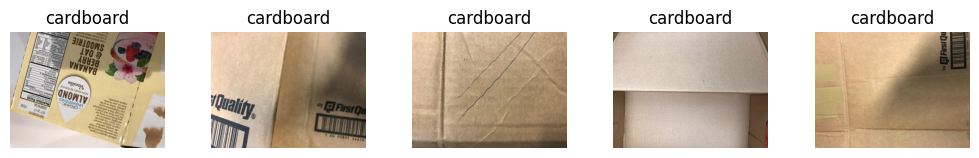

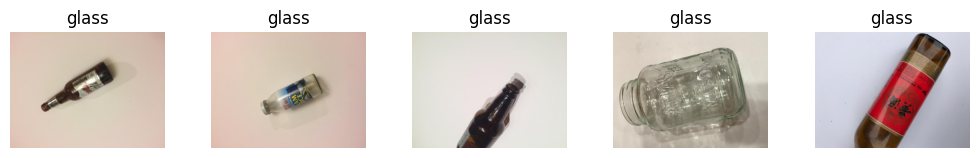

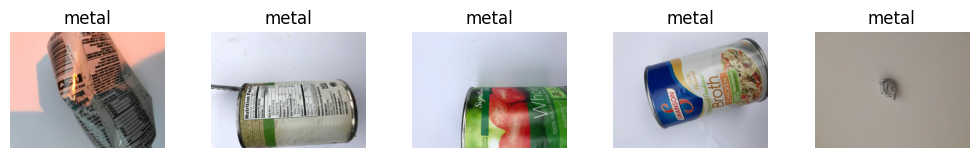

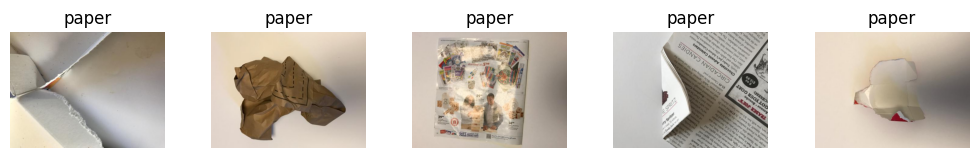

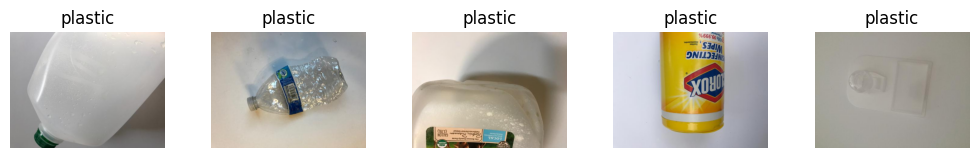

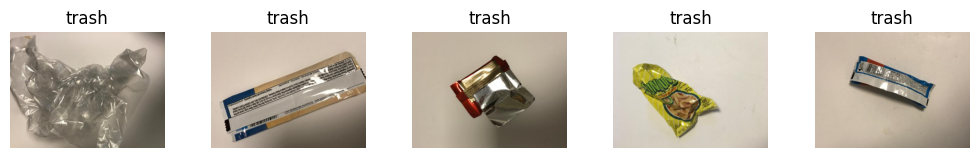

In [32]:

# Plot samples of Dataset
def plot_imgs(item_dir, top=10):
    all_item_dirs = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:5]
  
    plt.figure(figsize=(10, 10))
  
    for idx, img_path in enumerate(item_files):
        plt.subplot(5, 5, idx+1)
    
        img = plt.imread(img_path)
        plt.tight_layout()         
        plt.imshow(img, cmap='gray') 
        plt.axis('off')
        plt.title(os.path.basename(item_dir)) 

plot_imgs(data_path/'cardboard')
plot_imgs(data_path/'glass')
plot_imgs(data_path/'metal')
plot_imgs(data_path/'paper')
plot_imgs(data_path/'plastic')
plot_imgs(data_path/'trash')

In [36]:
# Define variable for requirements
batch_size = 30
target_size = (180, 180)
validation_split = 0.15

# Data Generators
train_img_generator = ImageDataGenerator(rescale=1./255,
                                         validation_split=validation_split,
                                         horizontal_flip=True,
                                         vertical_flip=True,
                                         zoom_range = 0.5,
                                         width_shift_range = 0.3,
                                         height_shift_range = 0.3,
                                         rotation_range=50,
                                         shear_range = 0.3,
                                         fill_mode='nearest'
                                        )

test_data_img_generator = ImageDataGenerator(rescale=1./255,
                                             validation_split=validation_split
                                            )

# Separate train Data
train_data = train_img_generator.flow_from_directory(data_path,
                                                        subset="training",
                                                        seed=133,
                                                        target_size=target_size,
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        color_mode='rgb',
                                                       )


# Separate validation Data
test_data = test_data_img_generator.flow_from_directory(data_path,
                                                        subset="validation",
                                                        seed=133,
                                                        target_size=target_size,
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        color_mode='rgb',
                                                       )

Found 2150 images belonging to 6 classes.
Found 377 images belonging to 6 classes.


In [37]:
class cnn_garbage:
    def __init__(self):
        self.model = self.get_model_structure()
        self.ES = EarlyStopping(monitor='val_loss', mode='min', patience=10)
        self.RLROP = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.1, min_lr=0.01)
        self.MCH = ModelCheckpoint('trash.h5', monitor='val_loss', mode='min', save_best_only=True)
        self.model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()]
             )
    
    def get_model_structure(self):
        model = Sequential()
        model.add(ZeroPadding2D(padding=(1, 1), input_shape=(target_size[0], target_size[1], 3)))
        model.add(Conv2D(32, (3, 3), activation='relu'))
        model.add(layers.Dropout(0.3))
        model.add(MaxPool2D((2, 2)))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(layers.Dropout(0.3))
        model.add(MaxPool2D((2, 2)))
        model.add(Conv2D(128, (3, 3), activation='relu'))
        model.add(layers.Dropout(0.4))
        model.add(MaxPool2D((2, 2)))
        model.add(layers.Flatten())
        model.add(layers.Dense(128, activation='relu'))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(64, activation='relu'))
        model.add(Dense(6, activation='softmax'))
        return model
    
    def train(self):
        history = self.model.fit(train_data,
                    steps_per_epoch=len(train_data),
                    epochs=500,
                    validation_data=test_data,
                    validation_steps=len(test_data),
                    callbacks=[self.ES, self.RLROP, self.MCH]
                   )
        return history

    def plot_model(self):
        plot_model(self.model, to_file='model.png', show_shapes=True)
        plt.figure(figsize=(10, 10))
        plt.imshow(plt.imread('model.png'))
        plt.axis('off')
        plt.show()
    

In [40]:
cnn = cnn_garbage()
history = cnn.train()
cnn.plot_model()


Epoch 1/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - categorical_accuracy: 0.2261 - loss: 2.2462

72/72 ━━━━━━━━━━━━━━━━━━━━ 20s 263ms/step - categorical_accuracy: 0.2267 - loss: 2.2404 - val_categorical_accuracy: 0.3899 - val_loss: 1.5867 - learning_rate: 0.0010
Epoch 2/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - categorical_accuracy: 0.3582 - loss: 1.5409

72/72 ━━━━━━━━━━━━━━━━━━━━ 20s 271ms/step - categorical_accuracy: 0.3580 - loss: 1.5411 - val_categorical_accuracy: 0.3793 - val_loss: 1.5516 - learning_rate: 0.0010
Epoch 3/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - categorical_accuracy: 0.3550 - loss: 1.5329

72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 293ms/step - categorical_accuracy: 0.3550 - loss: 1.5328 - val_categorical_accuracy: 0.3899 - val_loss: 1.4742 - learning_rate: 0.0010
Epoch 4/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - categorical_accuracy: 0.3757 - loss: 1.5037

72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 286ms/step - categorical_accuracy: 0.3759 - loss: 1.5035 - val_categorical_accuracy: 0.4271 - val_loss: 1.4703 - learning_rate: 0.0010
Epoch 5/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - categorical_accuracy: 0.4321 - loss: 1.4514

72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 289ms/step - categorical_accuracy: 0.4320 - loss: 1.4513 - val_categorical_accuracy: 0.4668 - val_loss: 1.4302 - learning_rate: 0.0010
Epoch 6/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - categorical_accuracy: 0.4250 - loss: 1.4523

72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 292ms/step - categorical_accuracy: 0.4254 - loss: 1.4513 - val_categorical_accuracy: 0.5119 - val_loss: 1.4098 - learning_rate: 0.0010
Epoch 7/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - categorical_accuracy: 0.4539 - loss: 1.3705

72/72 ━━━━━━━━━━━━━━━━━━━━ 22s 299ms/step - categorical_accuracy: 0.4541 - loss: 1.3702 - val_categorical_accuracy: 0.5146 - val_loss: 1.3846 - learning_rate: 0.0010
Epoch 8/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 293ms/step - categorical_accuracy: 0.4906 - loss: 1.2922 - val_categorical_accuracy: 0.3979 - val_loss: 1.4370 - learning_rate: 0.0010
Epoch 9/500
31/72 ━━━━━━━━━━━━━━━━━━━━ 11s 283ms/step - categorical_accuracy: 0.4561 - loss: 1.3588

KeyboardInterrupt: 